# Active Learning with an LLM oracle using `everyrow`

This notebook demonstrates how to use an LLM as a labeling oracle in an active learning pipeline for text classification using [`everyrow`](https://github.com/futuresearch/everyrow-sdk). 


Briefly, active learning is a setup where the model iteratively selects the most informative samples to be labeled, rather than labeling all data upfront. At each iteration, the model identifies examples it is most uncertain about and sends them to an **oracle** for labeling.

Usually, the oracle is a human annotator, or a group of them, which makes the process expensive and slow. In this case study we use an LLM as our oracle via `everyrow.agent_map`, enabling fast, scalable, and cost-effective labeling. At each iteration we also measure the LLM's labeling accuracy against the dataset's ground truth labels.

**Overview:** We use TF-IDF + LightGBM as the classifier on the DBpedia-14 text classification task (14 categories). We start with an initial seed dataset of 700 ground-truth-labeled examples (50 per class), train the classifier, use entropy-based uncertainty sampling to select 20 instances per round to query, call `everyrow.agent_map` to get labels for those instances, add them to the training set, and then train again. This process repeats for 10 iterations.

**Cost:** Each full run with 200 annotations costs ~$0.26.

See [everyrow.io](https://everyrow.io) for docs and API keys ($20 free credit).

See [everyrow-sdk](https://github.com/futuresearch/everyrow-sdk) for the GitHub repository

## How to Run

Requires Python 3.12+. Set up the environment using **one** of the options below.

### Option A: Using UV (recommended)

```bash
curl -LsSf https://astral.sh/uv/install.sh | sh   # install UV if needed
uv sync
uv run python -m ipykernel install --user --name active-learning-tutorial
```

Then select the **active-learning-tutorial** kernel in VS Code or JupyterLab.

### Option B: Using pip

```bash
python -m venv .venv
source .venv/bin/activate        # Windows: .venv\Scripts\activate
pip install everyrow datasets lightgbm scikit-learn pandas numpy matplotlib python-dotenv pydantic ipykernel
python -m ipykernel install --user --name active-learning-tutorial
```

Then select the **active-learning-tutorial** kernel in VS Code or JupyterLab.

### Option C: Install directly in the notebook

Skip the terminal setup and uncomment the `!pip install` cell below to install dependencies into your current kernel. Works on **Kaggle** and **Colab**.

### Configure your API key

Get a key from [everyrow.io/api-key](https://everyrow.io/api-key) ($20 free credit), then:
- **Kaggle**: *Add-ons > Secrets* — add `EVERYROW_API_KEY`
- **Local**: Create a `.env` file with `EVERYROW_API_KEY=<your-key>`
- **Colab/other**: Set `os.environ["EVERYROW_API_KEY"] = "your-key"` in a cell

## 1. Setup

In [ ]:
# Uncomment to install dependencies directly in the notebook (Option C)
# !pip install everyrow datasets lightgbm scikit-learn pandas numpy matplotlib python-dotenv pydantic

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal

from datasets import load_dataset
from lightgbm import LGBMClassifier
from pydantic import BaseModel, Field
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from everyrow.ops import agent_map
from everyrow.session import create_session
from everyrow.task import EffortLevel

/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Dataset parameters
SAMPLE_FRACTION = 0.05  # Take 5% stratified sample for faster demo
TEST_SIZE_FRACTION = 0.2
TRAIN_TEST_SPLIT_RANDOM_STATE = 42

# Active learning parameters
SEED_SIZE = 700      # Initial labeled examples (50 per class)
QUERY_SIZE = 20      # Samples to query per iteration
ITERATIONS = 10      # Number of AL iterations
RANDOM_STATE = 42

### Set your API Key

Get your API key from [everyrow.io/api-key](https://everyrow.io/api-key) ($20 free credit) and provide it using one of these methods:

1. **Kaggle**: Go to *Add-ons > Secrets*, add a secret named `EVERYROW_API_KEY` with your key
2. **Colab**: Click the key icon in the left sidebar, add a secret named `EVERYROW_API_KEY`
3. **`.env` file**: Create a `.env` file in your working directory containing `EVERYROW_API_KEY=<your-key>`
4. **Environment variable**: Set `EVERYROW_API_KEY` in your shell before launching Jupyter


In [ ]:
# Load API key: try Kaggle Secrets, then Colab Secrets, then .env file, then environment
if not os.environ.get("EVERYROW_API_KEY"):
    try:
        from kaggle_secrets import UserSecretsClient
        os.environ["EVERYROW_API_KEY"] = UserSecretsClient().get_secret("EVERYROW_API_KEY")
        print("Loaded API key from Kaggle Secrets")
    except (ImportError, Exception):
        try:
            from google.colab import userdata
            os.environ["EVERYROW_API_KEY"] = userdata.get("EVERYROW_API_KEY")
            print("Loaded API key from Colab Secrets")
        except (ImportError, Exception):
            from dotenv import load_dotenv, find_dotenv
            load_dotenv(find_dotenv(usecwd=True))

if not os.environ.get("EVERYROW_API_KEY"):
    raise ValueError(
        "EVERYROW_API_KEY not found. Get a key at https://everyrow.io/api-key\n"
        "Then set it via: Kaggle Secrets, Colab Secrets, a .env file, or an environment variable."
    )
print("API key configured")


API key configured


## 2. Load the Dataset

We'll use DBpedia-14, a text classification dataset with 14 categories. We use a 5% stratified sample (`dbpedia_tiny`) to keep the demo fast.

On huggingface it can be found here: https://huggingface.co/datasets/fancyzhx/dbpedia_14

In [ ]:
# DBpedia-14 category mapping
LABEL_NAMES = {
    0: "Company",
    1: "Educational Institution",
    2: "Artist",
    3: "Athlete",
    4: "Office Holder",
    5: "Mean Of Transportation",
    6: "Building",
    7: "Natural Place",
    8: "Village",
    9: "Animal",
    10: "Plant",
    11: "Album",
    12: "Film",
    13: "Written Work",
}
CATEGORY_TO_ID = {v: k for k, v in LABEL_NAMES.items()}

print(f"Categories: {list(LABEL_NAMES.values())}")

Categories: ['Company', 'Educational Institution', 'Artist', 'Athlete', 'Office Holder', 'Mean Of Transportation', 'Building', 'Natural Place', 'Village', 'Animal', 'Plant', 'Album', 'Film', 'Written Work']


In [ ]:
# Load dataset from HuggingFace (downloads ~500MB on first run, then cached)
print("Loading DBpedia dataset...")
dataset = load_dataset("fancyzhx/dbpedia_14")

# Convert to DataFrame
df = pd.DataFrame({
    "text": dataset["train"]["content"],
    "label": dataset["train"]["label"],
})
df["label_name"] = df["label"].map(LABEL_NAMES)

# Stratified sampling: take SAMPLE_FRACTION from each class to keep the dataset balanced
sampled_dfs = []
for label in df["label"].unique():
    label_df = df[df["label"] == label].sample(frac=SAMPLE_FRACTION, random_state=42)
    sampled_dfs.append(label_df)
df = pd.concat(sampled_dfs).reset_index(drop=True)

print(f"Dataset size: {len(df)} samples")
print(f"\nClass distribution:")
print(df["label_name"].value_counts())

Loading DBpedia dataset...


Dataset size: 28000 samples

Class distribution:
label_name
Company                    2000
Educational Institution    2000
Artist                     2000
Athlete                    2000
Office Holder              2000
Mean Of Transportation     2000
Building                   2000
Natural Place              2000
Village                    2000
Animal                     2000
Plant                      2000
Album                      2000
Film                       2000
Written Work               2000
Name: count, dtype: int64


In [ ]:
# Split into train and test sets
train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE_FRACTION,
    stratify=df["label"],
    random_state=TRAIN_TEST_SPLIT_RANDOM_STATE,
)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 22400
Test size: 5600


In [ ]:
# Preview some examples
print("Sample texts:\n")
for i, row in train_df.head(3).iterrows():
    print(f"[{row['label_name']}]")
    print(f"{row['text'][:200]}...\n")

Sample texts:

[Film]
 Charlie the Unicorn is a Flash animated short film and viral video directed produced animated and written by Jason Steele of independent film company FilmCow. The film follows the life of Charlie a l...

[Educational Institution]
 Geilston Bay High School is a co-educational state high school catering for students in grades 7 to 10 that is located in Geilston Bay. It is located within the City of Clarence which is a constituen...

[Building]
 The Union School at 174 Center St. in West Haven Connecticut was built in 1890. It was designed by architect Leoni W. Robinson. It has also become known as Union School Senior Housing. It was listed ...



## 3. Define the LLM Oracle

We use EveryRow's `agent_map` to classify texts using an LLM. The response is structured using a Pydantic model to ensure valid category outputs.

We use `EffortLevel.LOW` which routes to a fast, cost-effective model. Other options are `EffortLevel.MEDIUM` and `EffortLevel.HIGH` for tasks that require more reasoning.

In [ ]:
# Define the expected response format
class DBpediaClassification(BaseModel):
    category: Literal[
        "Company",
        "Educational Institution",
        "Artist",
        "Athlete",
        "Office Holder",
        "Mean Of Transportation",
        "Building",
        "Natural Place",
        "Village",
        "Animal",
        "Plant",
        "Album",
        "Film",
        "Written Work",
    ] = Field(description="The DBpedia ontology category")


# The task prompt for the LLM
ORACLE_TASK = """Classify this text into exactly one DBpedia ontology category:
- Company: Business organizations, corporations
- Educational Institution: Schools, universities, colleges
- Artist: Musicians, painters, actors, performers
- Athlete: Sports players, competitors
- Office Holder: Politicians, government officials
- Mean Of Transportation: Vehicles, aircraft, ships
- Building: Structures, landmarks, architectural works
- Natural Place: Geographic features, parks, bodies of water
- Village: Small settlements, towns
- Animal: Species of animals
- Plant: Species of plants, flowers, trees
- Album: Music albums, discographies
- Film: Movies, documentaries
- Written Work: Books, articles, publications

Return the most appropriate category based on the content."""

In [ ]:
async def query_llm_oracle(texts_df: pd.DataFrame) -> list[int]:
    """Query the LLM oracle to get labels for the given texts.
    
    Args:
        texts_df: DataFrame with a 'text' column
        
    Returns:
        List of label IDs (0-13), or -1 for failures
    """
    async with create_session(name="Active Learning Oracle") as session:
        result = await agent_map(
            session=session,
            task=ORACLE_TASK,
            input=texts_df[["text"]],
            response_model=DBpediaClassification,
            effort_level=EffortLevel.LOW,
        )
        
        labels = []
        for i in range(len(texts_df)):
            try:
                category = result.data["category"].iloc[i]
                label_id = CATEGORY_TO_ID.get(category, -1)
                labels.append(label_id)
            except Exception:
                print(f"Warning: Failed to parse result for row {i}")
                labels.append(-1)
        
        return labels

## 4. Define the Classifier

We use a simple but effective TF-IDF + LightGBM classifier. The TF-IDF vectorizer is fitted on the training data only to avoid leakage from the test set.

In [ ]:
class TextClassifier:
    """Text classifier using TF-IDF + LightGBM."""
    
    def __init__(self, vectorizer: TfidfVectorizer):
        self.vectorizer = vectorizer
        self.model = LGBMClassifier(
            n_estimators=100,
            num_leaves=31,
            learning_rate=0.1,
            verbose=-1,
        )
    
    def fit(self, texts: list[str], labels: list[int]):
        X = self.vectorizer.transform(texts)
        self.model.fit(X, labels)
    
    def predict(self, texts: list[str]) -> np.ndarray:
        X = self.vectorizer.transform(texts)
        return self.model.predict(X)
    
    def predict_proba(self, texts: list[str]) -> np.ndarray:
        X = self.vectorizer.transform(texts)
        return self.model.predict_proba(X)


def get_uncertainty_scores(classifier: TextClassifier, texts: list[str]) -> np.ndarray:
    """Compute entropy-based uncertainty scores."""
    probs = classifier.predict_proba(texts)
    entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
    return entropy


def evaluate(classifier: TextClassifier, test_df: pd.DataFrame) -> dict:
    """Evaluate classifier on test set."""
    preds = classifier.predict(test_df["text"].tolist())
    return {
        "accuracy": accuracy_score(test_df["label"], preds),
        "f1_macro": f1_score(test_df["label"], preds, average="macro"),
    }

In [ ]:
# Fit vectorizer on training data only (no test leakage)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(train_df["text"].tolist())

print(f"Vocabulary size: {len(vectorizer.vocabulary_)} features")

Vocabulary size: 5000 features


## 5. Run Active Learning

Now we run the active learning loop:

1. **Seed**: Start with a small balanced set using ground truth labels
2. **Iterate**: Train → Select uncertain samples → Query LLM → Add to training set

In [ ]:
def get_balanced_seed_indices(df: pd.DataFrame, seed_size: int, random_state: int) -> list[int]:
    """Sample balanced seed indices across classes."""
    labels = df["label"].unique()
    n_classes = len(labels)
    per_class = seed_size // n_classes
    remainder = seed_size % n_classes
    
    indices = []
    rng = np.random.default_rng(random_state)
    
    for i, label in enumerate(sorted(labels)):
        class_indices = df[df["label"] == label].index.tolist()
        n_samples = per_class + (1 if i < remainder else 0)
        sampled = rng.choice(class_indices, size=min(n_samples, len(class_indices)), replace=False)
        indices.extend(sampled.tolist())
    
    return indices

In [ ]:
async def run_active_learning():
    """Run the active learning loop."""
    rng = np.random.default_rng(RANDOM_STATE)
    
    # Initialize with balanced seed using ground truth labels
    labeled_indices = get_balanced_seed_indices(train_df, SEED_SIZE, RANDOM_STATE)
    unlabeled_set = set(range(len(train_df))) - set(labeled_indices)
    unlabeled_indices = list(unlabeled_set)
    rng.shuffle(unlabeled_indices)
    
    # Labels dict: index -> label (start with ground truth for seed)
    labels = {idx: train_df.iloc[idx]["label"] for idx in labeled_indices}
    
    # Track history for plotting
    history = []
    
    print(f"Starting with {len(labeled_indices)} seed samples (ground truth labels)")
    print(f"Unlabeled pool: {len(unlabeled_set)} samples")
    print(f"\n{'='*60}")
    
    for iteration in range(ITERATIONS + 1):
        # Build labeled dataset
        labeled_df = train_df.iloc[labeled_indices][["text"]].copy()
        labeled_df["label"] = [labels[idx] for idx in labeled_indices]
        
        # Train classifier
        classifier = TextClassifier(vectorizer)
        classifier.fit(labeled_df["text"].tolist(), labeled_df["label"].tolist())
        
        # Evaluate
        metrics = evaluate(classifier, test_df)
        history.append({
            "iteration": iteration,
            "n_labeled": len(labeled_indices),
            "accuracy": metrics["accuracy"],
            "f1_macro": metrics["f1_macro"],
        })
        
        print(f"Iteration {iteration}: {len(labeled_indices)} labeled, "
              f"Accuracy: {metrics['accuracy']:.3f}, F1: {metrics['f1_macro']:.3f}")
        
        # Stop if last iteration or no more unlabeled data
        if iteration == ITERATIONS or len(unlabeled_set) == 0:
            break
        
        # Select most uncertain samples
        unlabeled_texts = train_df.iloc[unlabeled_indices]["text"].tolist()
        uncertainties = get_uncertainty_scores(classifier, unlabeled_texts)
        top_k_idx = np.argsort(uncertainties)[-QUERY_SIZE:]
        query_indices = [unlabeled_indices[i] for i in top_k_idx]
        
        # Query LLM oracle
        print(f"  Querying LLM for {len(query_indices)} samples...")
        query_df = train_df.iloc[query_indices][["text"]].reset_index(drop=True)
        oracle_labels = await query_llm_oracle(query_df)
        
        # Calculate oracle accuracy vs ground truth
        true_labels = train_df.iloc[query_indices]["label"].tolist()
        valid_count = sum(1 for l in oracle_labels if l >= 0)
        correct_count = sum(1 for o, t in zip(oracle_labels, true_labels) if o == t and o >= 0)
        oracle_acc = correct_count / max(valid_count, 1)
        print(f"  Oracle accuracy: {oracle_acc:.1%} ({correct_count}/{valid_count} correct)")
        
        # Add valid labels to training set
        for idx, label in zip(query_indices, oracle_labels):
            unlabeled_set.discard(idx)
            if label >= 0:
                labeled_indices.append(idx)
                labels[idx] = label
        
        unlabeled_indices = [i for i in unlabeled_indices if i in unlabeled_set]
    
    print(f"{'='*60}")
    print(f"\nFinal: {len(labeled_indices)} labeled samples")
    print(f"Final Accuracy: {history[-1]['accuracy']:.3f}")
    print(f"Final F1 Macro: {history[-1]['f1_macro']:.3f}")
    
    return history

In [ ]:
# Run the active learning loop
# Note: top-level await works in Jupyter. In a .py script, use asyncio.run(run_active_learning())
history = await run_active_learning()

Starting with 700 seed samples (ground truth labels)
Unlabeled pool: 21700 samples



/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 0: 700 labeled, Accuracy: 0.756, F1: 0.755


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 95.0% (19/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 1: 720 labeled, Accuracy: 0.761, F1: 0.761


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 100.0% (20/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 2: 740 labeled, Accuracy: 0.767, F1: 0.767


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 90.0% (18/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 3: 760 labeled, Accuracy: 0.774, F1: 0.773


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 95.0% (19/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 4: 780 labeled, Accuracy: 0.783, F1: 0.783


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 100.0% (20/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 5: 800 labeled, Accuracy: 0.789, F1: 0.789


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 85.0% (17/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 6: 820 labeled, Accuracy: 0.785, F1: 0.785


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 100.0% (20/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 7: 840 labeled, Accuracy: 0.794, F1: 0.794


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 85.0% (17/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 8: 860 labeled, Accuracy: 0.791, F1: 0.790


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 95.0% (19/20 correct)


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteration 9: 880 labeled, Accuracy: 0.791, F1: 0.791


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Querying LLM for 20 samples...


  Oracle accuracy: 100.0% (20/20 correct)


Iteration 10: 900 labeled, Accuracy: 0.792, F1: 0.792

Final: 900 labeled samples
Final Accuracy: 0.792
Final F1 Macro: 0.792


/Users/rafaelpoyiadzi/Documents/git/3clone-delphos/cohort/engine/src/case_studies/active_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 6. Visualize Results

Plot the learning curve showing how accuracy improves as we add more LLM-labeled samples.

In [ ]:
# Convert history to DataFrame
history_df = pd.DataFrame(history)
history_df

,iteration,n_labeled,accuracy,f1_macro
0,0,700,0.756429,0.755408
1,1,720,0.761250,0.760568
2,2,740,0.767500,0.767101
3,3,760,0.773929,0.773314
4,4,780,0.782857,0.782722
5,5,800,0.788750,0.788816
6,6,820,0.785000,0.784842
7,7,840,0.793750,0.793949
8,8,860,0.790536,0.790253
9,9,880,0.790714,0.790642


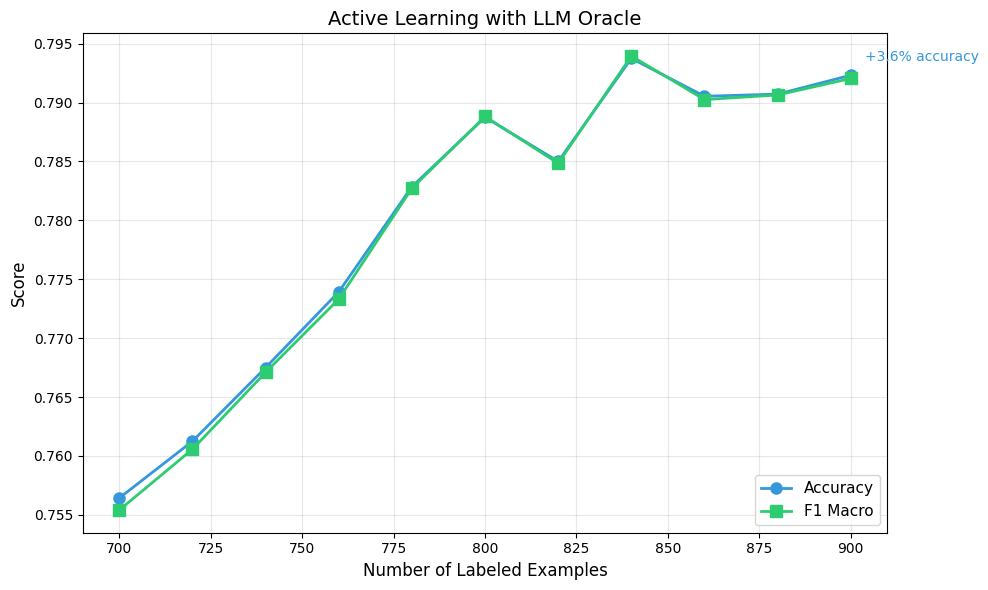

In [ ]:
# Plot learning curve
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(history_df["n_labeled"], history_df["accuracy"], 
        marker="o", linewidth=2, markersize=8, label="Accuracy", color="#3498db")
ax.plot(history_df["n_labeled"], history_df["f1_macro"], 
        marker="s", linewidth=2, markersize=8, label="F1 Macro", color="#2ecc71")

ax.set_xlabel("Number of Labeled Examples", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Active Learning with LLM Oracle", fontsize=14)
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotation for improvement
start_acc = history_df["accuracy"].iloc[0]
end_acc = history_df["accuracy"].iloc[-1]
improvement = end_acc - start_acc
ax.annotate(f"+{improvement:.1%} accuracy", 
            xy=(history_df["n_labeled"].iloc[-1], end_acc),
            xytext=(10, 10), textcoords="offset points",
            fontsize=10, color="#3498db")

plt.tight_layout()
plt.show()

## 7. Conclusion

This notebook demonstrated a complete active learning pipeline using an LLM as a labeling oracle via `everyrow.agent_map`.

**Links:** [everyrow SDK on GitHub](https://github.com/futuresearch/everyrow-sdk) | [everyrow.io](https://everyrow.io) | [DBpedia-14 dataset](https://huggingface.co/datasets/fancyzhx/dbpedia_14)
